# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy.interpolate import interp1d
from diffrax import Kvaerno3
import jax

np.set_printoptions(threshold=np.inf)

from jax import config
config.update("jax_enable_x64", True)

import sys
sys.path.append('..')

from hyrex.hyrex import recomb_model

from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

# Running HyRex

In [3]:
h = jnp.float64(0.7)
omega_b = jnp.float64(0.0224)
omega_cdm = jnp.float64(0.12)
Neff = jnp.float64(3.044)
YHe = jnp.float64(0.245)
z_reion = 11
Delta_z_reion = 0.5

In [4]:
rmodel = recomb_model()

In [5]:
# wrap inputs in jnp.asarray to avoid recompilation
xe_full_reion, lna_full, Tm, lna_Tm = rmodel(jnp.asarray(h),
                                                         jnp.asarray(omega_b),
                                                         jnp.asarray(omega_cdm),
                                                         jnp.asarray(Neff),
                                                         jnp.asarray(YHe),
                                                         jnp.asarray(z_reion), # defaults to 11
                                                         jnp.asarray(Delta_z_reion) # defaults to 0.5
                                                        )

## An aside: `array_with_padding`

`get_history` returns an `array_with_padding` object.  This is because our differential equation solver `diffrax` pads output arrays with `jnp.inf` to maintain a fixed array size at compile time.  The arrays returned by this computation retain this padding, but `array_with_padding` has built-in functions meant to help you extract only the parts of the array with finite values.


So some care must be taken to extract array values.  Use either `.arr` or call with `()` to get array values:


In [6]:
z_full = jnp.exp(-lna_full.arr) - 1
print(z_full[-50:])
print(len(z_full))

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
28925


The end of the array is all -1, since the end of `lna_full.arr` is all `jnp.inf`.  Let's truncate the array before the `inf`s start with `.lastnum`:

In [7]:
z_full = jnp.exp(-lna_full.arr[:lna_full.lastnum]) - 1
print(z_full[-50:])
print(len(z_full))

[-0.04703603 -0.0475124  -0.04798852 -0.04846441 -0.04894006 -0.04941547
 -0.04989064 -0.05036558 -0.05084028 -0.05131474 -0.05178896 -0.05226295
 -0.0527367  -0.05321021 -0.05368349 -0.05415653 -0.05462933 -0.0551019
 -0.05557423 -0.05604633 -0.05651818 -0.05698981 -0.05746119 -0.05793235
 -0.05840326 -0.05887394 -0.05934439 -0.0598146  -0.06028457 -0.06075431
 -0.06122382 -0.06169309 -0.06216213 -0.06263093 -0.0630995  -0.06356783
 -0.06403593 -0.06450379 -0.06497142 -0.06543882 -0.06590598 -0.06637292
 -0.06683961 -0.06730608 -0.06777231 -0.0682383  -0.06870407 -0.0691696
 -0.0696349  -0.07009996]
18121


Note the array got shorter, and we only converted finite values of `lna_full` to `z` (no more padding at the end).

If you would like to access the last finite value of the output array, you can do so with `.lastval`:

In [8]:
last_lna = lna_full.lastval
print(last_lna)

0.07317818715072734


## Plotting HyRax results

Text(0, 0.5, '$x_e$')

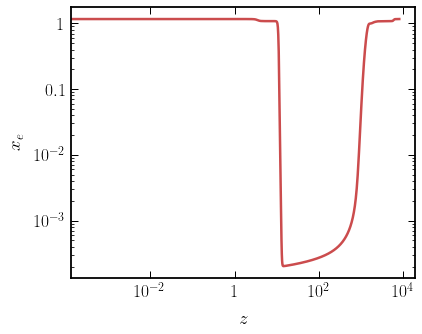

In [9]:
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum])    # padding size is the same for lna_full and
                                                                # xe_full_reion, so either could be used to 
                                                                # index here
plt.xlabel('$z$')
plt.ylabel('$x_e$')

For easy comparison, we store some output of HYREC-2 in `notebooks/HYREC-2_results`.  `Planck_params` was run with
```
h = 0.7
omega_b = 0.0224
omega_cdm = 0.12
Neff = 3.044
YHe = 0.245
```
while `extra_params` was run with
```
h = 0.674
omega_b = 0.04*h**2
omega_cdm = 0.26*h**2
Neff = 3.044
YHe = 0.245.
```
We compare the results for the parameters more closely matching Planck:

In [10]:
hyrec2out = np.loadtxt('HYREC-2_results/Planck_params.dat')

In [11]:
z_hyrec = hyrec2out[:,0]
xe_hyrec = hyrec2out[:,1]
Tm_hyrec = hyrec2out[:,2] # this is in K

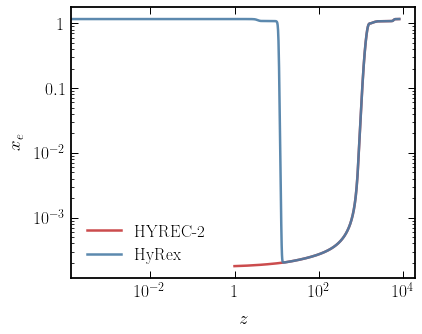

In [12]:
plt.loglog(z_hyrec,xe_hyrec,label='HYREC-2')
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum],label='HyRex')


plt.xlabel('$z$')
plt.ylabel('$x_e$')

plt.legend()

The difference at low $z$ is due to reionization, which is not computed in HYREC-2 output.

We can add that in by hand (or alternatively set `z_reion` and `Delta_z_reion` to 0 in the HyRex call):

In [13]:
fHe = YHe / 4 / (1-YHe)
z = z_hyrec
y = (1+z)**(3./2)

y_reion = (1+z_reion)**(3./2)
Delta_y_reion = 3./2 * jnp.sqrt(1+z_reion) * Delta_z_reion
tanh_arg = (y_reion - y) / Delta_y_reion

xe_reion_correction = (1+fHe)/2 * (1 + jnp.tanh(tanh_arg))
hyrec_with_reion =  xe_hyrec + xe_reion_correction

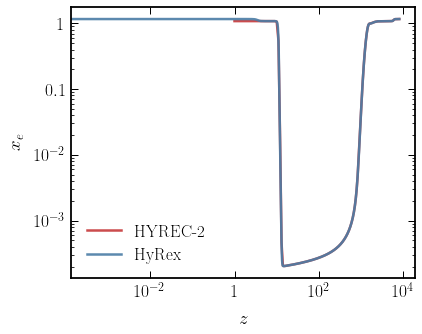

In [14]:
plt.loglog(z_hyrec,hyrec_with_reion,label='HYREC-2')
plt.loglog(z_full,xe_full_reion.arr[:xe_full_reion.lastnum],label='HyRex')


plt.xlabel('$z$')
plt.ylabel('$x_e$')

plt.legend()

We can see that the agreement sub percent-level:

Text(0, 0.5, '$\\frac{x_{e,{\\rm{HyRex}}} - x_{e,\\rm{HYREC2}}}{x_{e,\\rm{HYREC2}}}$')

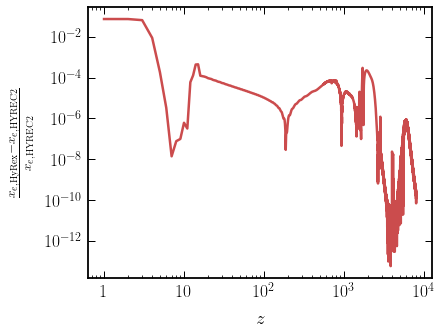

In [15]:
xe_hyrex_interp = interp1d(z_full,xe_full_reion.arr[:xe_full_reion.lastnum])
plt.loglog(z_hyrec,np.abs(xe_hyrex_interp(z_hyrec)-hyrec_with_reion)/hyrec_with_reion)
plt.xlabel('$z$')
plt.ylabel(r'$\frac{x_{e,{\rm{HyRex}}} - x_{e,\rm{HYREC2}}}{x_{e,\rm{HYREC2}}}$')